In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

In [36]:
Data = pd.read_csv('test_new.csv')

In [37]:
Data.info()
Data.describe().transpose()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1883 entries, 0 to 1882
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   name    1883 non-null   object 
 1   energy  1883 non-null   float64
 2   diag    1883 non-null   float64
 3   pca1    1883 non-null   float64
 4   pca2    1883 non-null   float64
 5   pca3    1883 non-null   float64
dtypes: float64(5), object(1)
memory usage: 88.4+ KB


,count,mean,std,min,25%,50%,75%,max
energy,1883.0,24.416358,27.288977,0.354965,0.409214,0.582452,38.118049,75.461656
diag,1883.0,0.248627,0.277354,0.005000,0.005000,0.005000,0.378000,0.754000
pca1,1883.0,0.184568,0.229187,-0.687571,0.034178,0.068929,0.268753,0.870534
pca2,1883.0,0.109284,0.273241,-0.651034,0.025515,0.071592,0.194131,0.814977
pca3,1883.0,0.088417,0.280693,-0.828189,0.025299,0.097596,0.239532,0.849920


In [38]:
null_counts = Data.isna().sum()
null_counts

name      0
energy    0
diag      0
pca1      0
pca2      0
pca3      0
dtype: int64

<AxesSubplot: >

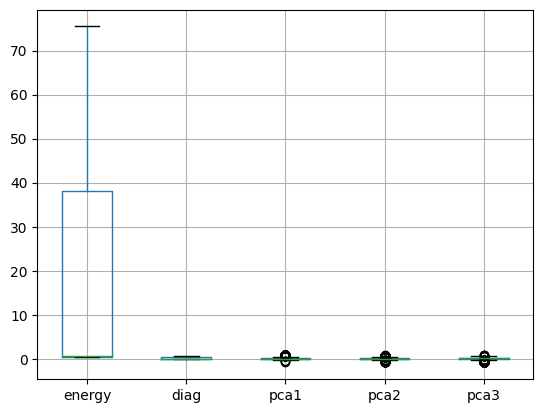

In [39]:
features = ['energy','diag','pca1', 'pca2', 'pca3']
Data.boxplot(features)

In [40]:
selected_features = ['diag','pca1','pca2','pca3']
X = Data[selected_features]

In [41]:
target =  ['energy']
y = Data[target]

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)


In [43]:
xgb_model = XGBRegressor(objective='reg:squarederror')

In [44]:
# param_grid = {
#     'n_estimators': [100, 500, 1000],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [3, 4, 5],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.8, 0.9, 1.0],
#     'reg_alpha': [0, 0.01, 1],  # Add regularization term
#     'reg_lambda': [0.1, 1, 3]  # Add regularization term
# }


In [45]:
#Less Complex model to avoid overfitting
param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],  # Lower maximum depth to reduce complexity
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.01, 0.1],  # Use smaller values for L1 regularization
    'reg_lambda': [0.1, 1, 3]     # Use smaller values for L2 regularization
}


In [46]:
grid_search = GridSearchCV(
    xgb_model, 
    param_grid, 
    scoring='neg_mean_absolute_error',
    cv=5,
    verbose=1
)

In [47]:
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 500, 1000],
                         'reg_alpha': [0, 0.01, 0.1], 'reg_lambda': [0.1, 1, 3],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='neg_mean_absolute_error', verbose=1)

In [48]:
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

Best parameters found:  {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 1.0}


In [49]:
best_model = grid_search.best_estimator_

In [50]:
# Add early stopping to the fit method
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ['mae']
best_model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, early_stopping_rounds=10, verbose=False)


C:\Users\gts\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\gts\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [51]:
y_pred_train = best_model.predict(X_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
print(f"Mean absolute error on training set: {mae_train:.3f}")

Mean absolute error on training set: 0.007


In [52]:
y_pred_test = best_model.predict(X_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
print(f"Mean absolute error on testing set: {mae_test:.3f}")

Mean absolute error on testing set: 0.022


In [53]:
predicted_output_train = best_model.predict(X_train)
actual_output_train = y_train.values.flatten()

In [54]:
df_train = pd.DataFrame({'Predicted Energy': predicted_output_train, 'Actual Energy': actual_output_train})
print(df_train.head(10))

   Predicted Energy  Actual Energy
0          0.414943       0.407728
1         35.536720      35.524720
2          0.409631       0.403193
3          0.412186       0.412096
4         38.116722      38.117303
5         71.044540      71.035855
6         75.454666      75.460568
7          0.473831       0.469109
8         38.144749      38.144999
9          0.424370       0.402846


In [55]:
results = best_model.evals_result()
train_loss = results['validation_0']['mae']
test_loss = results['validation_1']['mae']

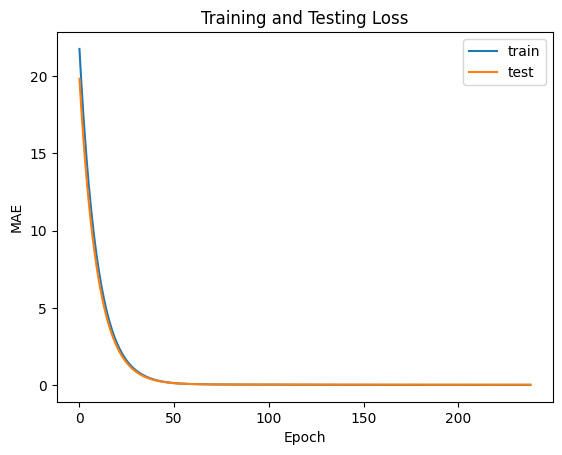

In [56]:
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.legend()
plt.title('Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.show()